In [2]:
%load_ext autoreload
%autoreload 2

from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt

import ccxt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
from scipy.stats import t

S0_sonic = 0.3
S0_sol = 173
vol_sonic = 0.8
vol_sol = 0.6
mu_sonic = 0
mu_sol = 0
T = 417 / 365
N = 417
dt = T / N
M = 10000
beta = 0.8

# Calculate correlation from beta
corr = beta * vol_sol / vol_sonic
corr = np.clip(corr, -1.0, 1.0)  # Ensure correlation is within valid range

# Cholesky decomposition
cov_matrix = np.array([[1.0, corr], [corr, 1.0]])
L = np.linalg.cholesky(cov_matrix)

# Degrees of freedom for t-distribution (lower df => heavier tails)
df = 3

# Generate t-distributed random variables
Z = t.rvs(df, size=(2, N * M))

# Scale to match desired standard deviation
Z *= np.sqrt((df - 2) / df)

# Apply Cholesky decomposition
correlated_Z = L @ Z
correlated_Z = correlated_Z.reshape(2, N, M)

# Initialize price paths
sonic_paths = np.zeros((N + 1, M))
sol_paths = np.zeros((N + 1, M))
sonic_paths[0] = S0_sonic
sol_paths[0] = S0_sol

# Simulate paths
for t in range(1, N + 1):
    sonic_paths[t] = sonic_paths[t - 1] * np.exp((mu_sonic - 0.5 * vol_sonic ** 2) * dt + vol_sonic * np.sqrt(dt) * correlated_Z[0, t - 1])
    sol_paths[t] = sol_paths[t - 1] * np.exp((mu_sol - 0.5 * vol_sol ** 2) * dt + vol_sol * np.sqrt(dt) * correlated_Z[1, t - 1])


/Users/tracystephens/Projects/Trading/crypto_momentum/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


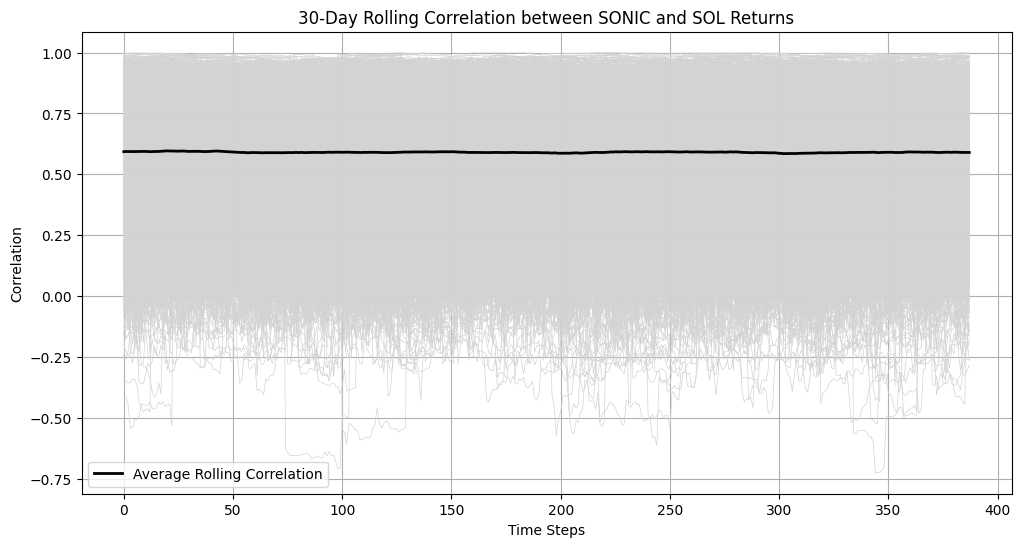

In [217]:
# Parameters
window_size = 30  # Rolling window size

# Step 1: Compute log returns
sonic_returns = np.log(sonic_paths[1:] / sonic_paths[:-1])  # Shape: (N, M)
sol_returns = np.log(sol_paths[1:] / sol_paths[:-1])        # Shape: (N, M)

# Step 2: Compute rolling correlations for each path
rolling_corrs = np.full((N - window_size + 1, M), np.nan)  # Initialize array

for i in range(M):
    df = pd.DataFrame({
        'SONIC': sonic_returns[:, i],
        'SOL': sol_returns[:, i]
    })
    rolling_corr = df['SONIC'].rolling(window=window_size).corr(df['SOL'])
    rolling_corrs[:, i] = rolling_corr.dropna().values  # Drop NaNs resulting from rolling


# # Optional: Compute average rolling correlation across all paths
average_rolling_corr = np.nanmean(rolling_corrs, axis=1)

# Plot all rolling correlations in light gray
plt.figure(figsize=(12, 6))
for i in range(M):
    plt.plot(rolling_corrs[:, i], color='lightgray', linewidth=0.5)

# Plot the average rolling correlation in black
plt.plot(average_rolling_corr, color='black', linewidth=2, label='Average Rolling Correlation')

plt.title(f'{window_size}-Day Rolling Correlation between SONIC and SOL Returns')
plt.xlabel('Time Steps')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()

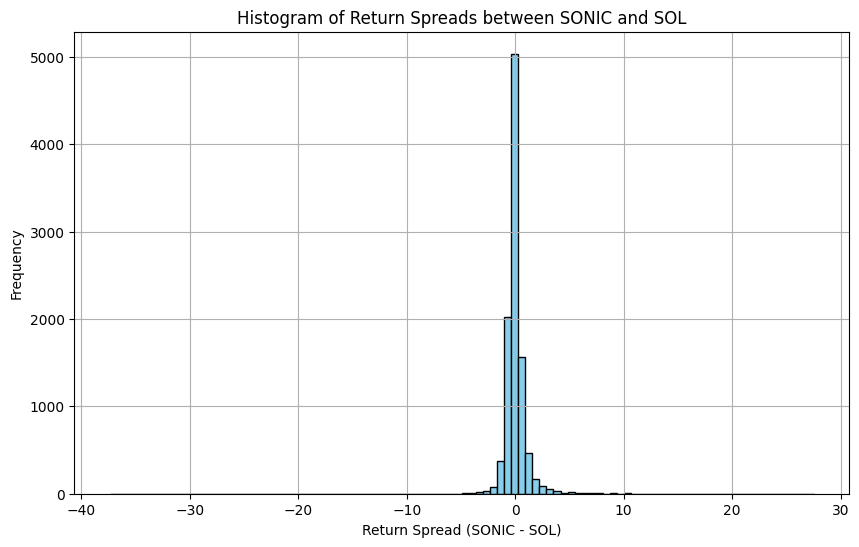

In [218]:
# Step 1: Compute total returns for each path
sonic_total_returns = sonic_paths[-1] / sonic_paths[0] - 1  # Shape: (M,)
sol_total_returns = sol_paths[-1] / sol_paths[0] - 1        # Shape: (M,)

# Step 2: Compute return spreads
return_spreads = sonic_total_returns - sol_total_returns    # Shape: (M,)

# Step 3: Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(return_spreads, bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Return Spreads between SONIC and SOL')
plt.xlabel('Return Spread (SONIC - SOL)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Axes: >

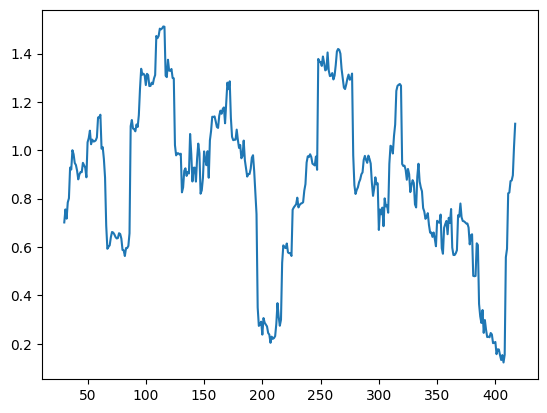

In [219]:
# Extract price series
sonic_series = pd.Series(sonic_paths[:, 1])
sol_series = pd.Series(sol_paths[:, 1])

# Compute daily log returns
sonic_returns = np.log(sonic_series / sonic_series.shift(1))
sol_returns = np.log(sol_series / sol_series.shift(1))

window = 30
rolling_cov = sonic_returns.rolling(window).cov(sol_returns)
rolling_var = sol_returns.rolling(window).var()
rolling_beta = rolling_cov / rolling_var

rolling_beta.plot()

In [221]:
import numpy_financial as npf

def simulate_hedge(
    sonic_path,
    sol_path,
    discount=0.6,
    sonic_hedge=0.4,
    sol_hedge=0.4,
    sonic_funding=-0.4,
    sol_funding=-0.05,
    n_tokens=7500000,
    weeks=59,
    starting_beta=0.8,
    min_margin_sonic=0.3,
    min_margin_sol=0.3,
):
    sonic_series = pd.Series(sonic_path)
    sol_series = pd.Series(sol_path)

    # Compute rolling beta
    sonic_returns = np.log(sonic_series / sonic_series.shift(1))
    sol_returns = np.log(sol_series / sol_series.shift(1))
    window = 30
    rolling_cov = sonic_returns.rolling(window).cov(sol_returns)
    rolling_var = sol_returns.rolling(window).var()
    rolling_beta = (rolling_cov / rolling_var).fillna(starting_beta)

    weekly_sonic = sonic_path[::7][:weeks+1]
    weekly_sol = sol_path[::7][:weeks+1]
    weekly_beta = rolling_beta.iloc[::7][:weeks+1]

    sonic_long = n_tokens
    sonic_short = sonic_long * sonic_hedge
    sonic_collateral = 0
    sonic_funding_paid = 0
    sonic_realized_pnl = 0

    sol_short_base = n_tokens * sol_hedge
    sol_short_size = rolling_beta.iloc[0] * (sol_short_base * weekly_sonic[0] / weekly_sol[0])
    sol_collateral = 0
    sol_funding_paid = 0
    sol_realized_pnl = 0

    prev_sol_short_size = sol_short_size
    prev_sol_price = weekly_sol[0]

    # Initial purchase cost at discount
    initial_price = weekly_sonic[0]
    purchase_cost = n_tokens * initial_price * (1 - discount)

    details = {}

    for t in range(weeks + 1):
        current_sonic = weekly_sonic[t]
        current_sol = weekly_sol[t]
        current_beta = weekly_beta.iloc[t]
        time_year = t / 52.0

        # Sonic short
        sonic_notional = sonic_short * current_sonic
        sonic_collateral_new = sonic_notional * min_margin_sonic
        sonic_collateral_flow = -(sonic_collateral_new - sonic_collateral)
        sonic_collateral = sonic_collateral_new
        sonic_funding_cost = 0 if t == 0 else (sonic_funding / 52) * sonic_notional
        sonic_funding_paid += sonic_funding_cost
        sonic_cf = sonic_collateral_flow + sonic_funding_cost

        # SOL short
        sol_short_size = current_beta * (sol_short_base * current_sonic / current_sol)
        sol_notional = sol_short_size * current_sol
        sol_collateral_new = sol_notional * min_margin_sol
        sol_collateral_flow = -(sol_collateral_new - sol_collateral)
        sol_collateral = sol_collateral_new
        sol_funding_cost = 0 if t == 0 else (sol_funding / 52) * sol_notional
        sol_funding_paid += sol_funding_cost

        # Realized PnL from resizing SOL short
        sol_delta_pnl = (prev_sol_price - current_sol) * prev_sol_short_size if t > 0 else 0
        sol_realized_pnl += sol_delta_pnl
        prev_sol_short_size = sol_short_size
        prev_sol_price = current_sol

        sol_cf = sol_collateral_flow + sol_funding_cost + sol_delta_pnl

        total_cf = sol_cf + sonic_cf
        if t == 0:
            total_cf -= purchase_cost  # add purchase cost only on week 0

        details[t] = {
            'week': t,
            'sonic_price': current_sonic,
            'sol_price': current_sol,
            'beta': current_beta,
            'remaining_sonic_long': sonic_long,
            'sonic_hedge': sonic_short,
            'sonic_short_notional': sonic_notional,
            'sonic_funding_paid': sonic_funding_paid,
            'sonic_collateral': sonic_collateral,
            'sonic_collateral_flow': sonic_collateral_flow,
            'sonic_realized_pnl': 0.0,
            'sonic_cashflow': sonic_cf,
            'sol_short_notional': sol_notional,
            'sol_short_size': sol_short_size,
            'sol_funding_paid': sol_funding_paid,
            'sol_collateral': sol_collateral,
            'sol_collateral_flow': sol_collateral_flow,
            'sol_realized_pnl': sol_delta_pnl,
            'sol_cashflow': sol_cf,
            'total_cashflow': total_cf,
        }

    # Final settlement
    final_sonic_price = weekly_sonic[weeks]
    final_sol_price = weekly_sol[weeks]

    # Realize SONIC hedge PnL
    sonic_realized_pnl = (weekly_sonic[0] - final_sonic_price) * sonic_short
    final_sonic_sale = final_sonic_price * sonic_long  # Sell all tokens at final price

    details[weeks + 1] = {
        'week': weeks + 1,
        'sonic_price': final_sonic_price,
        'sol_price': final_sol_price,
        'beta': rolling_beta.iloc[weeks],
        'remaining_sonic_long': 0,
        'sonic_hedge': 0,
        'sonic_short_notional': 0,
        'sonic_funding_paid': sonic_funding_paid,
        'sonic_collateral': 0,
        'sonic_collateral_flow': sonic_collateral,
        'sonic_realized_pnl': sonic_realized_pnl,
        'sonic_cashflow': sonic_collateral + sonic_realized_pnl + final_sonic_sale,
        'sol_short_notional': 0,
        'sol_short_size': 0,
        'sol_funding_paid': sol_funding_paid,
        'sol_collateral': 0,
        'sol_collateral_flow': sol_collateral,
        'sol_realized_pnl': 0.0,
        'sol_cashflow': sol_collateral,
        'total_cashflow': sonic_collateral + sonic_realized_pnl + final_sonic_sale + sol_collateral,
    }

    return pd.DataFrame(details).T

# Define IRR function
def irr(cash_flows):
    irr = npf.irr(cash_flows)
    return (1 + irr) ** 52 - 1 if irr is not None else None

In [222]:
discount = 0.6
sonic_hedge = 0.4
sol_hedge = 0.4
unhedged = 0.2
sonic_funding = -0.4
sol_funding = -0.05
n_tokens = 7500000
weeks = 59
min_margin_sonic = 0.3
min_margin_sol = 0.3

path = 1
sonic_path = sonic_paths[:, path]
sol_path = sol_paths[:, path]

df = simulate_hedge(
    sonic_path, 
    sol_path,
    discount=discount,
    sonic_hedge=sonic_hedge,
    sonic_funding=sonic_funding,
    sol_funding=sol_funding,
    n_tokens=n_tokens,
    weeks=weeks,
    starting_beta=beta,
    min_margin_sonic=min_margin_sonic,
    min_margin_sol=min_margin_sol,
)

df.to_clipboard()

irr(df['total_cashflow'].values)   

0.6825937015997097

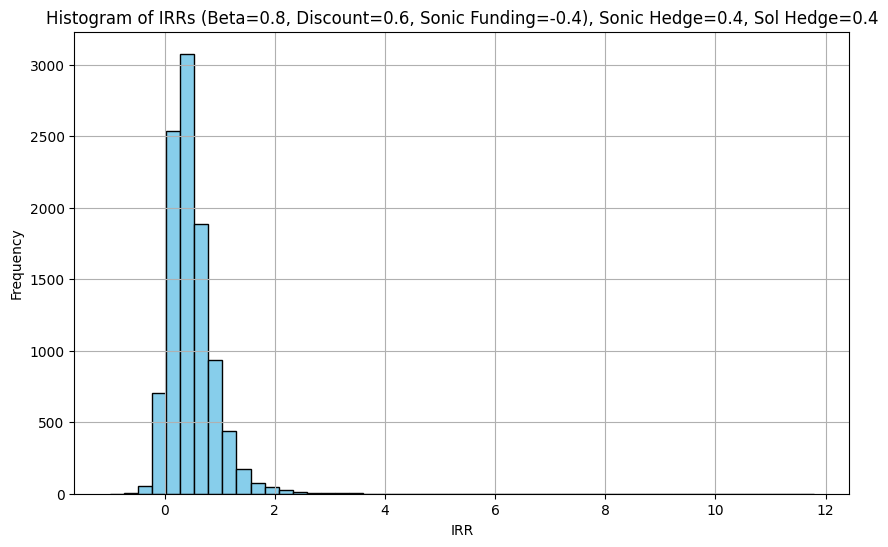

Min IRR: -0.9964
Max IRR: 11.7918
Mean IRR: 0.4857
10th Percentile: 0.0642
25th Percentile (Q1): 0.2169
Median (Q2): 0.4153
75th Percentile (Q3): 0.6736
90th Percentile: 0.9768
Percentage of IRRs > 0: 93.84%


In [232]:
discount = 0.6
sonic_hedge = 0.4
sol_hedge = 0.4
unhedged = 0.2
sonic_funding = -0.4
sol_funding = -0.05
n_tokens = 7500000
weeks = 59
min_margin_sonic = 0.3
min_margin_sol = 0.3

# Calculate IRR for each path
sims = {}
irrs = []
for path in range(M):
    sonic_path = sonic_paths[:, path]
    sol_path = sol_paths[:, path]
    
    df = simulate_hedge(
        sonic_path, 
        sol_path,
        discount=discount,
        sonic_hedge=sonic_hedge,
        sol_hedge=sol_hedge,
        sonic_funding=sonic_funding,
        sol_funding=sol_funding,
        n_tokens=n_tokens,
        weeks=weeks,
        starting_beta=beta,
    )
    sims[path] = df
    
    path_irr = irr(df['total_cashflow'].values)
    irrs.append(path_irr)

# Plot histogram of IRRs
plt.figure(figsize=(10, 6))
plt.hist(irrs, bins=50, color='skyblue', edgecolor='black')
plt.title(f'Histogram of IRRs (Beta={beta}, Discount={discount}, Sonic Funding={sonic_funding}), Sonic Hedge={sonic_hedge}, Sol Hedge={sol_hedge}')
plt.xlabel('IRR')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f"Min IRR: {np.min(irrs):.4f}")
print(f"Max IRR: {np.max(irrs):.4f}")
print(f"Mean IRR: {np.mean(irrs):.4f}")
print(f"10th Percentile: {np.percentile(irrs, 10):.4f}")
print(f"25th Percentile (Q1): {np.percentile(irrs, 25):.4f}")
print(f"Median (Q2): {np.percentile(irrs, 50):.4f}")
print(f"75th Percentile (Q3): {np.percentile(irrs, 75):.4f}")
print(f"90th Percentile: {np.percentile(irrs, 90):.4f}")
# Calculate the percentage of IRRs greater than 0
pct_positive_irr = np.mean(np.array(irrs) > 0) * 100
print(f"Percentage of IRRs > 0: {pct_positive_irr:.2f}%")

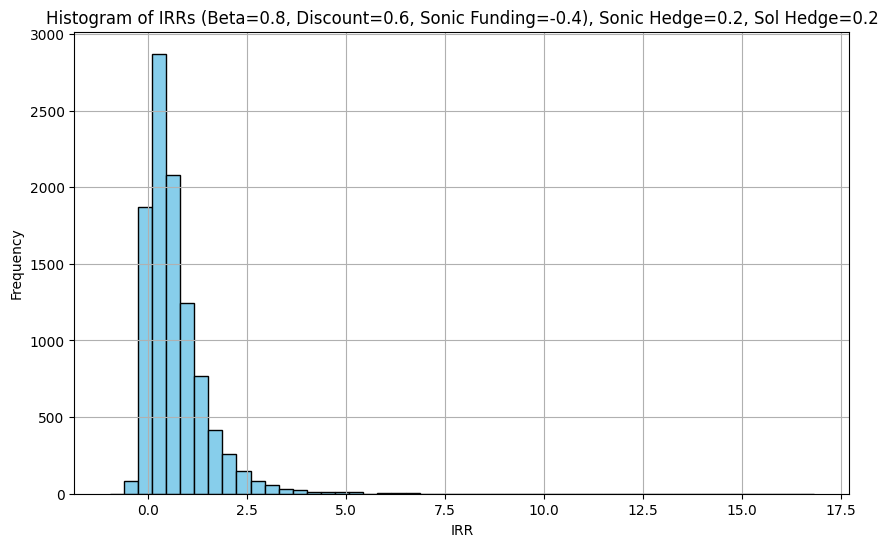

Min IRR: -0.9715
Max IRR: 16.8176
Mean IRR: 0.6756
10th Percentile: -0.0372
25th Percentile (Q1): 0.1604
Median (Q2): 0.4776
75th Percentile (Q3): 0.9475
90th Percentile: 1.5674
Percentage of IRRs > 0: 87.38%


In [231]:
discount = 0.6
sonic_hedge = 0.2
sol_hedge = 0.2
unhedged = 0.6
sonic_funding = -0.4
sol_funding = -0.05
n_tokens = 7500000
weeks = 59
min_margin_sonic = 0.3
min_margin_sol = 0.3

# Calculate IRR for each path
sims = {}
irrs = []
for path in range(M):
    sonic_path = sonic_paths[:, path]
    sol_path = sol_paths[:, path]
    
    df = simulate_hedge(
        sonic_path, 
        sol_path,
        discount=discount,
        sonic_hedge=sonic_hedge,
        sol_hedge=sol_hedge,
        sonic_funding=sonic_funding,
        sol_funding=sol_funding,
        n_tokens=n_tokens,
        weeks=weeks,
        starting_beta=beta,
    )
    sims[path] = df
    
    path_irr = irr(df['total_cashflow'].values)
    irrs.append(path_irr)

# Plot histogram of IRRs
plt.figure(figsize=(10, 6))
plt.hist(irrs, bins=50, color='skyblue', edgecolor='black')
plt.title(f'Histogram of IRRs (Beta={beta}, Discount={discount}, Sonic Funding={sonic_funding}), Sonic Hedge={sonic_hedge}, Sol Hedge={sol_hedge}')
plt.xlabel('IRR')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f"Min IRR: {np.min(irrs):.4f}")
print(f"Max IRR: {np.max(irrs):.4f}")
print(f"Mean IRR: {np.mean(irrs):.4f}")
print(f"10th Percentile: {np.percentile(irrs, 10):.4f}")
print(f"25th Percentile (Q1): {np.percentile(irrs, 25):.4f}")
print(f"Median (Q2): {np.percentile(irrs, 50):.4f}")
print(f"75th Percentile (Q3): {np.percentile(irrs, 75):.4f}")
print(f"90th Percentile: {np.percentile(irrs, 90):.4f}")
# Calculate the percentage of IRRs greater than 0
pct_positive_irr = np.mean(np.array(irrs) > 0) * 100
print(f"Percentage of IRRs > 0: {pct_positive_irr:.2f}%")

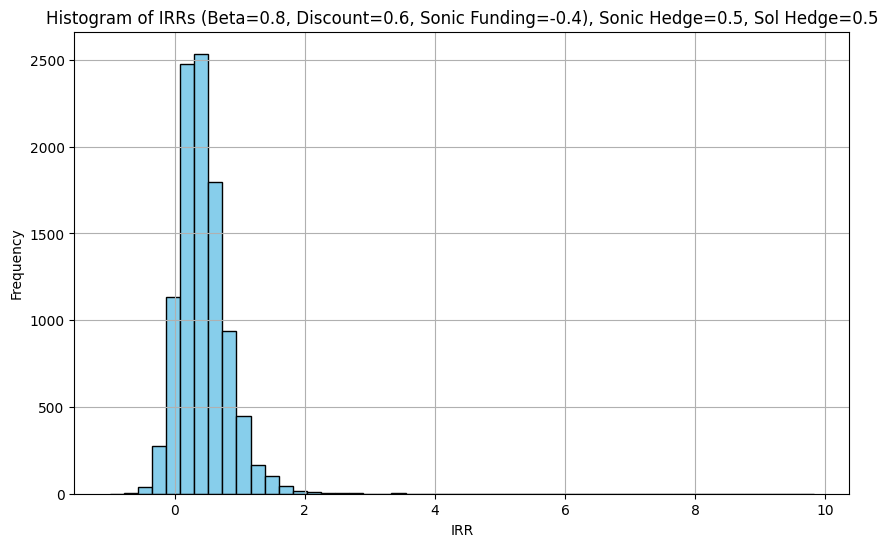

Min IRR: -0.9982
Max IRR: 9.8301
Mean IRR: 0.4330
10th Percentile: 0.0236
25th Percentile (Q1): 0.1856
Median (Q2): 0.3914
75th Percentile (Q3): 0.6265
90th Percentile: 0.8893
Percentage of IRRs > 0: 91.33%


In [230]:
discount = 0.6
sonic_hedge = 0.5
sol_hedge = 0.5
unhedged = 0
sonic_funding = -0.4
sol_funding = -0.05
n_tokens = 7500000
weeks = 59
min_margin_sonic = 0.3
min_margin_sol = 0.3

# Calculate IRR for each path
sims = {}
irrs = []
for path in range(M):
    sonic_path = sonic_paths[:, path]
    sol_path = sol_paths[:, path]
    
    df = simulate_hedge(
        sonic_path, 
        sol_path,
        discount=discount,
        sonic_hedge=sonic_hedge,
        sol_hedge=sol_hedge,
        sonic_funding=sonic_funding,
        sol_funding=sol_funding,
        n_tokens=n_tokens,
        weeks=weeks,
        starting_beta=beta,
    )
    sims[path] = df
    
    path_irr = irr(df['total_cashflow'].values)
    irrs.append(path_irr)

# Plot histogram of IRRs
plt.figure(figsize=(10, 6))
plt.hist(irrs, bins=50, color='skyblue', edgecolor='black')
plt.title(f'Histogram of IRRs (Beta={beta}, Discount={discount}, Sonic Funding={sonic_funding}), Sonic Hedge={sonic_hedge}, Sol Hedge={sol_hedge}')
plt.xlabel('IRR')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f"Min IRR: {np.min(irrs):.4f}")
print(f"Max IRR: {np.max(irrs):.4f}")
print(f"Mean IRR: {np.mean(irrs):.4f}")
print(f"10th Percentile: {np.percentile(irrs, 10):.4f}")
print(f"25th Percentile (Q1): {np.percentile(irrs, 25):.4f}")
print(f"Median (Q2): {np.percentile(irrs, 50):.4f}")
print(f"75th Percentile (Q3): {np.percentile(irrs, 75):.4f}")
print(f"90th Percentile: {np.percentile(irrs, 90):.4f}")
# Calculate the percentage of IRRs greater than 0
pct_positive_irr = np.mean(np.array(irrs) > 0) * 100
print(f"Percentage of IRRs > 0: {pct_positive_irr:.2f}%")

In [ ]:
# ## price path assumptions
# S0_sonic = 0.3
# S0_sol = 173
# vol_sonic = 0.8
# vol_sol = 0.6
# mu_sonic = 0
# mu_sol = 0
# T = 417 / 365
# N = 417
# dt = T / N
# M = 10000
# beta = 0.8

# ## return assumptions
# discount = 0.6
# sonic_hedge = 0.4
# sol_hedge = 0.4
# unhedged = 0.2
# sonic_funding = -0.4
# sol_funding = -0.05
# n_tokens = 7500000
# weeks = 59